In [8]:
from ParametricGraphModels.ADC_SBM import ADC_SBM, from_config
from config import Scenarios
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import sem  

In [92]:
illustrative_1 = {

        "name": "perfect",
        "task": "multiclass",

        "community_sizes": [50, 50, 50],  # fixed
        "cluster_sizes": [50, 50, 50],  # same as com_size -> overlap
        "m_features": 6,
        # "k_clusters": 4,
        "alpha": 2, "beta": 20, "lmbd": .5,

        "between_com_prob_range": (.1, .1),
        "within_com_prob_range": (.5, .5),  # within_range > between -> assortative

        "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
        "within_clust_variance_range": (1, 1),

        "within_clust_covariance_range": (0, .0),  # not important; fixed
        "centroid_covariance_range": (0, 0),  # not important; fixed

        "n_targets": 3,
        "degree_importance": 0,  # irrelevant

        "x_importance": 6,
        "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

        "community_importance": 6,  # this scale shouldn't be interpreted analog to x and degree
        "community_importance_exponent": 1,
        "model_error": 2,
        "splitweights": [.7, .2, .1]

    }

illustrative_2 = {
    # Well seperated by community-connectivity + homophily. But irrelevant features, with poor cluster separation.

    "name": "community_relevant",
    "task": "multiclass",

    "community_sizes": [200, 200, 200],
    "cluster_sizes": [200, 300, 100],
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.1, .1),
    "within_com_prob_range": (.5, .5),  # within_range > between -> assortative

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (5, 5),

    "within_clust_covariance_range": (0, 0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 3,
    "degree_importance": 0,  # no meaningfully interpretation

    "x_importance": 1,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 6,  # diag entries
    "community_importance_exponent": 1,
    "model_error": 3,
    "splitweights": [.7, .2, .1]

}  # community relevant   

illustrative_3 = {

    # Relevant community (in terms of parameter) but heterophilic graph.
    # Features are mildly relevant.

    "name": "community_relevant_heterophilic",
    "task": "multiclass",

    "community_sizes": [50, 50, 50],
    "cluster_sizes": [70, 60, 20],   # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.4, .4),
    "within_com_prob_range": (.55, .55),

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (1, 1),

    "within_clust_covariance_range": (0, 0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 3,
    "degree_importance": 0,  # no meaningfully interpretation

    "x_importance": 1,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 6,  # diag entries
    "community_importance_exponent": 1,
    "model_error": 3,
    "splitweights": [.7, .2, .1]

}

illustrative_4 = {
    # Well seperated by features-cluster with relevant parameters.
    # However, no edge clustering and no relevance of community belonging.

    "name": "cluster_relevant",
    "task": "multiclass",

    "community_sizes": [70, 60, 20],  # fixed
    "cluster_sizes": [50, 50, 50],  # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.5, .5),
    "within_com_prob_range": (.25, .25),

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (1, 1),

    "within_clust_covariance_range": (0, .0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 3,
    "degree_importance": 1,

    "x_importance": 6,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 1,  # this scale shouldn't be interpreted analog to x and degree
    "community_importance_exponent": 1,
    "model_error": 3,
    "splitweights": [.7, .2, .1]

}

illustrative_5 = {
    # Feature cluster explains target well, but clusters are not well seperated.
    # Communities are well seperated, but not really relevant.

    "name": "non_seperated_cluster_relevant",
    "task": "multiclass",

    "community_sizes": [70, 60, 20],  # fixed
    "cluster_sizes": [50, 50, 50],  # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.05, .05),
    "within_com_prob_range": (.4, .4),  # heterophilic

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (4, 4),

    "within_clust_covariance_range": (0, .0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 3,
    "degree_importance": 0,

    "x_importance": 6,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 1,  # this scale shouldn't be interpreted analog to x and degree
    "community_importance_exponent": 1,
    "model_error": 3,
    "splitweights": [.7, .2, .1]

}

illustrative_6 = {

    "name": "noise",
    "task": "multiclass",

    "community_sizes": [70, 40, 20],  # fixed
    "cluster_sizes": [20, 40, 70],  # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4,
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.5, .5),
    "within_com_prob_range": (.25, .25),  # within_range > between -> assortative

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (5, 5),

    "within_clust_covariance_range": (0, .0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 3,
    "degree_importance": 1,

    "x_importance": 1,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 1.5,  # this scale shouldn't be interpreted analog to x and degree
    "community_importance_exponent": 1,
    "model_error": 9,
    "splitweights": [.7, .2, .1]

}

100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


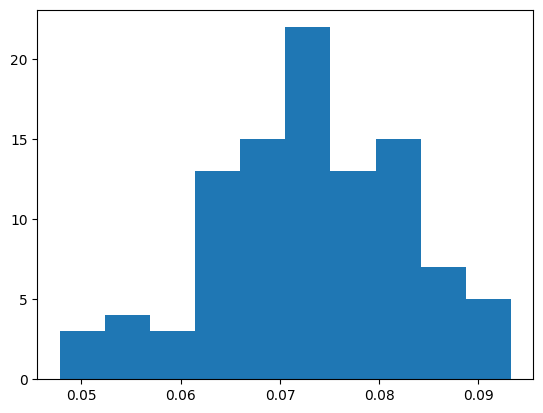

[0.0932602  0.07293912 0.06147197 0.05556276 0.06626711 0.07345532
 0.07195648 0.08895123 0.08408836 0.06440421 0.08009946 0.06767409
 0.06133094 0.08269502 0.09263567 0.05698718 0.09170293 0.04818446
 0.07721005 0.06736264 0.06738016 0.0759646  0.06760065 0.07180691
 0.07184807 0.07586956 0.08292535 0.07146919 0.07302995 0.06545715
 0.07759904 0.06689653 0.08632619 0.06727749 0.06254545 0.08036257
 0.07670291 0.07399965 0.0552673  0.07379004 0.05875715 0.06744644
 0.07085774 0.08432304 0.07448885 0.06839968 0.07897767 0.07199946
 0.08475142 0.06993879 0.07519802 0.06910029 0.0541752  0.07116172
 0.07919204 0.08459317 0.07281277 0.07458204 0.08123555 0.07125994
 0.06797331 0.06524866 0.08602833 0.06558566 0.0648644  0.06339222
 0.0811076  0.0705943  0.08439104 0.07103107 0.05613877 0.06395297
 0.07684276 0.08017166 0.07671143 0.09120272 0.0747089  0.06191861
 0.07038627 0.08528529 0.06163841 0.08175898 0.0807827  0.07963918
 0.08200918 0.08012864 0.07550258 0.07417166 0.06274139 0.0696

In [94]:
def plot_edge_homophily(scenario_config,n_iter):

    res = np.zeros(n_iter).reshape(-1)
    for i in tqdm(range(0,n_iter)):
        g = from_config(scenario_config, i)
        res[i] = g.edge_homophily()
    plt.hist(res)
    plt.show()
    
    return res
 
print(plot_edge_homophily(illustrative_3, 100))

100%|██████████| 100/100 [00:06<00:00, 14.39it/s]


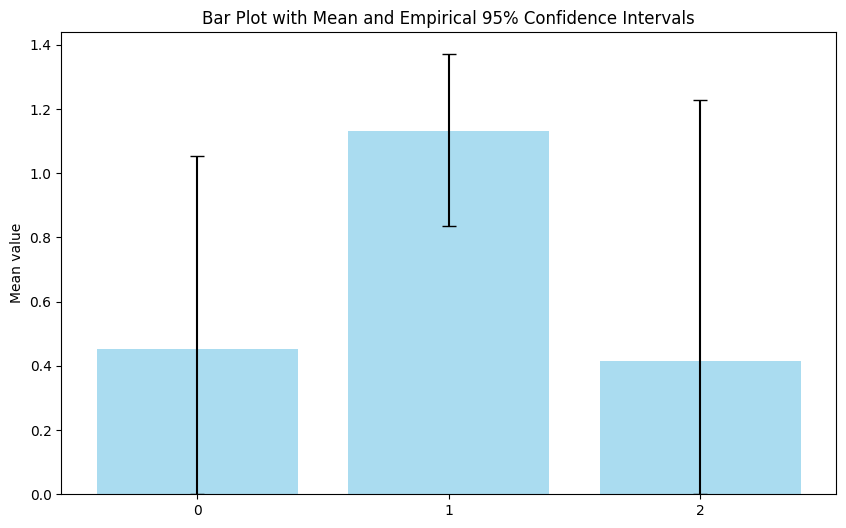

[[ 2.86396954e-01  4.68995591e-01  7.47584675e-01  2.86396954e-01
   2.86396954e-01 -1.44269516e-09  7.47584675e-01  2.86396954e-01
   2.86396954e-01  7.47584675e-01  8.84183715e-01 -1.44269516e-09
   2.86396954e-01  4.68995591e-01  4.68995591e-01  2.86396954e-01
   5.68995589e-01  7.47584675e-01  7.47584675e-01  1.15677965e+00
   7.47584675e-01  6.09840302e-01 -1.44269516e-09  2.86396954e-01
   2.86396954e-01  1.05401577e+00  2.86396954e-01 -1.44269516e-09
   2.86396954e-01  5.68995589e-01  7.47584675e-01  2.86396954e-01
   2.86396954e-01 -1.44269516e-09  4.68995591e-01  6.09840302e-01
   7.47584675e-01 -1.44269516e-09 -1.44269516e-09  7.47584675e-01
   8.84183715e-01  2.86396954e-01  2.86396954e-01  4.68995591e-01
   8.84183715e-01  2.86396954e-01  2.86396954e-01  5.68995589e-01
   6.09840302e-01  7.47584675e-01  7.47584675e-01  2.86396954e-01
   8.11278122e-01 -1.44269516e-09  2.86396954e-01  7.47584675e-01
  -1.44269516e-09 -1.44269516e-09  9.21928091e-01  2.86396954e-01
   2.86396

In [88]:
def plot_purity(scenario_config, n_iter, c="cluster", alpha=10):

    n_c = len(scenario_config[f"{c}_sizes"])
    res = np.zeros((n_c, n_iter))
    
    for i in tqdm(range(0, n_iter)):
        g = from_config(scenario_config, i)
        p = g.purity(metric="entropy")["centroids"]
        res[:, i] = p

    means = np.mean(res, axis=1)

    lower_bounds = np.percentile(res, alpha, axis=1)
    upper_bounds = np.percentile(res, (100-alpha), axis=1)
    
    lower_errors = means - lower_bounds
    upper_errors = upper_bounds - means
    
    conf_intervals = np.array([lower_errors, upper_errors])

    plt.figure(figsize=(10, 6))
    plt.bar([str(i) for i,_ in enumerate(means)], means, yerr=conf_intervals, capsize=5, color='skyblue', alpha=0.7)
    plt.ylabel('Mean value')
    plt.title('Bar Plot with Mean and Empirical 95% Confidence Intervals')
    plt.show()
  
    return res

print(plot_purity(illustrative_2, 100, alpha=2.5))

100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


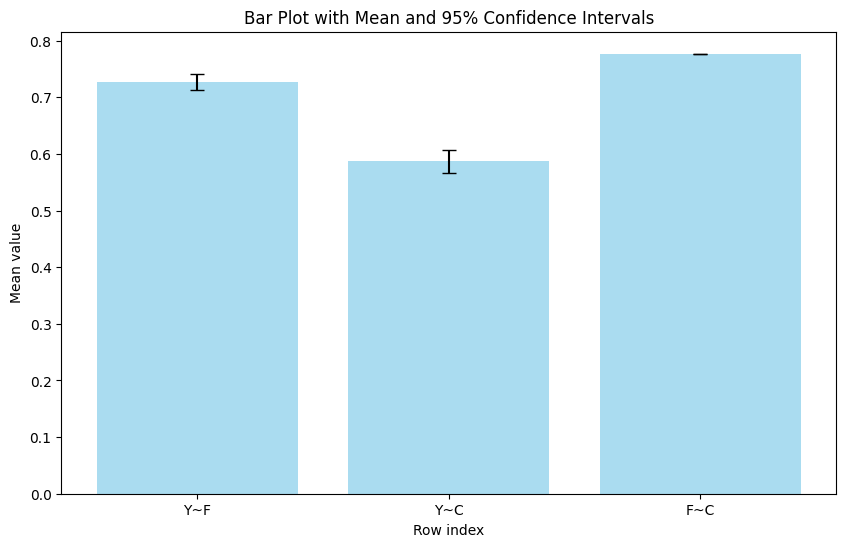

[[0.73713915 0.74114008 0.72331543 0.70891624]
 [0.59835554 0.60683513 0.5598383  0.58238734]
 [0.77710066 0.77710066 0.77710066 0.77710066]]


In [49]:
def plot_corr(scenario_config, n_iter, metric = 1):
    """
    
    :param scenario_config: 
    :param n_iter: 
    :param metric: 1: NMI
    :return: 
    """

    res = np.zeros((3, n_iter))
    for i in tqdm(range(0, n_iter)):
        g = from_config(scenario_config, i)
        lc = g.label_correlation()
        res[:,i] = lc.iloc[1, :]
    
    means = np.mean(res, axis=1)
    conf_intervals = sem(res, axis=1) * 1.96  
    
    plt.figure(figsize=(10, 6))
    plt.bar(["Y~F", "Y~C", "F~C"], means, yerr=conf_intervals, capsize=5, color='skyblue', alpha=0.7)

    plt.ylabel('NMI')
    plt.title('Bar Plot with Mean and 95% Confidence Intervals')
    plt.show()
    
    return res

print(plot_corr(Scenarios.non_seperated_cluster_relevant, 4))

